In [2]:
pip install pyodbc pandas


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pyodbc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Connect to SQL Server
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=abomousa;"              # Replace with your server name
    "Database=Instant_sprint_1;"    # Replace with your database name
    "Trusted_Connection=yes;"       # Use Windows Authentication
)

cursor = conn.cursor()


In [6]:
# Simple SQL query from the transactions table
query = "SELECT TOP 10 * FROM transactions"

# Read the results into a DataFrame
df = pd.read_sql(query, conn)

# Display the first 10 rows
df


,id,date,client_id,card_id,amount,use_chip,merchant_name,merchant_zip,mcc,errors
0,7475327,2010-01-01,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,"58523.0,5499,"
1,7475328,2010-01-01,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,"52722.0,5311,"
2,7475329,2010-01-01,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,"92084.0,4829,"
3,7475331,2010-01-01,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,"46307.0,4829,"
4,7475332,2010-01-01,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,"20776.0,5813,"
5,7475333,2010-01-01,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,"10464.0,5942,"
6,7475334,2010-01-01,1556,2972,$77.00,Swipe Transaction,59935,Beulah,ND,"58523.0,5499,"
7,7475335,2010-01-01,1684,2140,$26.46,Online Transaction,39021,ONLINE,None,",4784,"
8,7475336,2010-01-01,335,5131,$261.58,Online Transaction,50292,ONLINE,None,",7801,"
9,7475337,2010-01-01,351,1112,$10.74,Swipe Transaction,3864,Flushing,NY,"11355.0,5813,"


In [8]:
query = """
SELECT 
    transactions.id AS transaction_id,
    transactions.date,
    UsersData.id AS user_id,
    UsersData.gender,
    UsersData.yearly_income,
    CardsData.card_brand,
    CardsData.card_type,
    transactions.amount,
    transactions.merchant_name,
    transactions.use_chip
FROM transactions
LEFT JOIN UsersData 
    ON transactions.client_id = UsersData.id
LEFT JOIN CardsData 
    ON transactions.card_id = CardsData.id
ORDER BY transactions.date DESC;
"""

df = pd.read_sql(query, conn)
print(df.head())


   transaction_id        date  user_id  gender yearly_income  card_brand  \
0        23761874  2019-10-31      489    Male        $36753        Visa   
1        23761873  2019-10-31     1986  Female        $48430        Visa   
2        23761870  2019-10-31      199  Female        $78329  Mastercard   
3        23761869  2019-10-31     1766    Male        $20377  Mastercard   
4        23761868  2019-10-31     1718  Female        $33483  Mastercard   

         card_type  amount merchant_name            use_chip  
0  Debit (Prepaid)  $12.88         24658    Chip Transaction  
1            Debit   $4.00         46284    Chip Transaction  
2            Debit  $40.44          2925   Swipe Transaction  
3            Debit  $12.80         39261  Online Transaction  
4            Debit   $1.11         86438    Chip Transaction  


In [9]:
df.isna().sum()


transaction_id    0
date              0
user_id           0
gender            0
yearly_income     0
card_brand        0
card_type         0
amount            0
merchant_name     0
use_chip          0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [16]:
df.shape

(13305915, 10)

In [33]:
# 2. تحويل الأعمدة اللي فيها $ لأرقام
money_columns = ['yearly_income', 'amount']
for col in money_columns:
    df[col] = df[col].replace('[\$,]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [39]:
# 4. تحويل عمود التاريخ
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [41]:
# 5. استخراج السنة والشهر من التاريخ
df['transaction_year'] = df['date'].dt.year
df['transaction_month'] = df['date'].dt.month


In [45]:
print(df.head())

   transaction_id       date  user_id  gender  yearly_income  card_brand  \
0        23761874 2019-10-31      489    Male          36753        Visa   
1        23761873 2019-10-31     1986  Female          48430        Visa   
2        23761870 2019-10-31      199  Female          78329  Mastercard   
3        23761869 2019-10-31     1766    Male          20377  Mastercard   
4        23761868 2019-10-31     1718  Female          33483  Mastercard   

         card_type  amount merchant_name            use_chip  \
0  Debit (Prepaid)   12.88         24658    Chip Transaction   
1            Debit    4.00         46284    Chip Transaction   
2            Debit   40.44          2925   Swipe Transaction   
3            Debit   12.80         39261  Online Transaction   
4            Debit    1.11         86438    Chip Transaction   

   transaction_year  transaction_month  
0              2019                 10  
1              2019                 10  
2              2019                

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   transaction_id     int64         
 1   date               datetime64[ns]
 2   user_id            int64         
 3   gender             object        
 4   yearly_income      int64         
 5   card_brand         object        
 6   card_type          object        
 7   amount             float64       
 8   merchant_name      object        
 9   use_chip           object        
 10  transaction_year   int32         
 11  transaction_month  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(5)
memory usage: 1.1+ GB


In [37]:
df.describe()

,transaction_id,user_id,yearly_income,amount
count,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07
mean,1.558402e+07,1.026812e+03,4.668369e+04,4.297604e+01
std,4.704499e+06,5.816386e+02,2.444509e+04,8.165575e+01
min,7.475327e+06,0.000000e+00,1.000000e+00,-5.000000e+02
25%,1.150604e+07,5.190000e+02,3.281700e+04,8.930000e+00
50%,1.557087e+07,1.070000e+03,4.106900e+04,2.899000e+01
75%,1.965361e+07,1.531000e+03,5.401300e+04,6.371000e+01
max,2.376187e+07,1.998000e+03,2.801990e+05,6.820200e+03


In [47]:
# to see what is inside categorical columns
data_categorical = df.select_dtypes(include= 'object')
for col in data_categorical:
  print(f"\nunique values for '{col}': ")
  print(df[col].unique())


unique values for 'gender': 
['Male' 'Female']

unique values for 'card_brand': 
['Visa' 'Mastercard' 'Amex' 'Discover']

unique values for 'card_type': 
['Debit (Prepaid)' 'Debit' 'Credit']

unique values for 'merchant_name': 
['24658' '46284' '2925' ... '50517' '80353' '53405']

unique values for 'use_chip': 
['Chip Transaction' 'Swipe Transaction' 'Online Transaction']


In [51]:
upper_limit = df.amount.mean() + 3 * df.amount.std()
upper_limit

287.94328198505076

In [53]:
# احسب الحد السفلي والعلوي
lower_limit = df.amount.mean() - 3 * df.amount.std()
upper_limit = df.amount.mean() + 3 * df.amount.std()

# عد القيم اللي بره الحدود
outliers = df[(df.amount < lower_limit) | (df.amount > upper_limit)]

print("عدد الـ outliers:", len(outliers))
print("نسبة الـ outliers من البيانات: ", len(outliers) / len(df) * 100, "%")

#النسبة قليلة نسبيًا (< 5%) → ده طبيعي ومقبول جدًا في الـ real datasets.

عدد الـ outliers: 217412
نسبة الـ outliers من البيانات:  1.6339500139599568 %


In [57]:
df['gender'].value_counts()


gender
Female    6815916
Male      6489999
Name: count, dtype: int64

In [59]:
df['card_brand'].value_counts()


card_brand
Mastercard    7157399
Visa          4957563
Amex           854490
Discover       336463
Name: count, dtype: int64

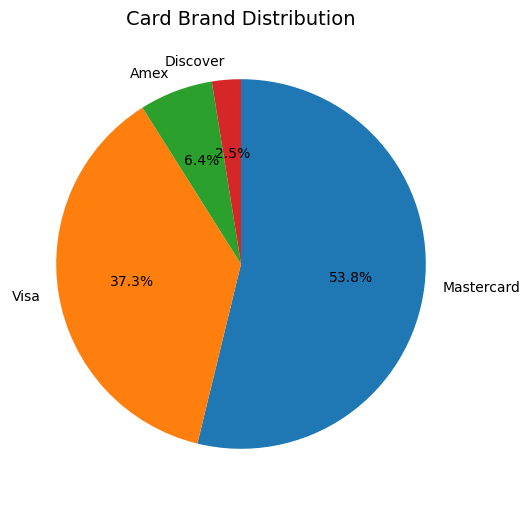

In [71]:
import matplotlib.pyplot as plt

# حساب النسب
card_counts = df['card_brand'].value_counts()

# رسم الـ Pie Chart
plt.figure(figsize=(6,6))   # بدل (6,6) خليها (4,4) أو أصغر حسب ما تحب
plt.pie(card_counts, 
        labels=card_counts.index, 
        autopct='%1.1f%%',   # يكتب النسبة جوة الدايرة
        startangle=90,       # يبدأ من فوق
        counterclock=False)  # اتجاه عقارب الساعة

plt.title("Card Brand Distribution", fontsize=14)
plt.show()


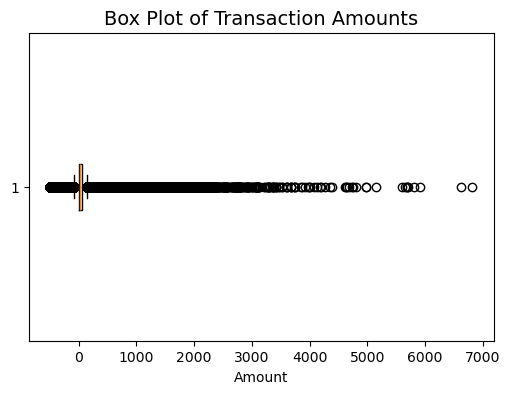

In [73]:
import matplotlib.pyplot as plt

# رسم Box Plot
plt.figure(figsize=(6,4))
plt.boxplot(df['amount'], vert=False)  # horizontal boxplot
plt.title("Box Plot of Transaction Amounts", fontsize=14)
plt.xlabel("Amount")
plt.show()

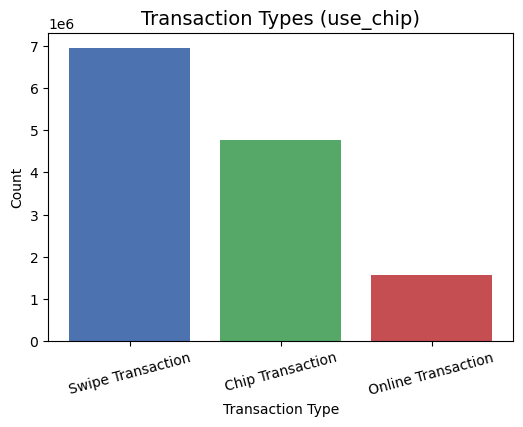

In [75]:
import matplotlib.pyplot as plt

# حساب عدد كل نوع من طرق الدفع
chip_counts = df['use_chip'].value_counts()

# رسم Bar Chart
plt.figure(figsize=(6,4))
plt.bar(chip_counts.index, chip_counts.values, color=['#4C72B0','#55A868','#C44E52'])
plt.title("Transaction Types (use_chip)", fontsize=14)
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()


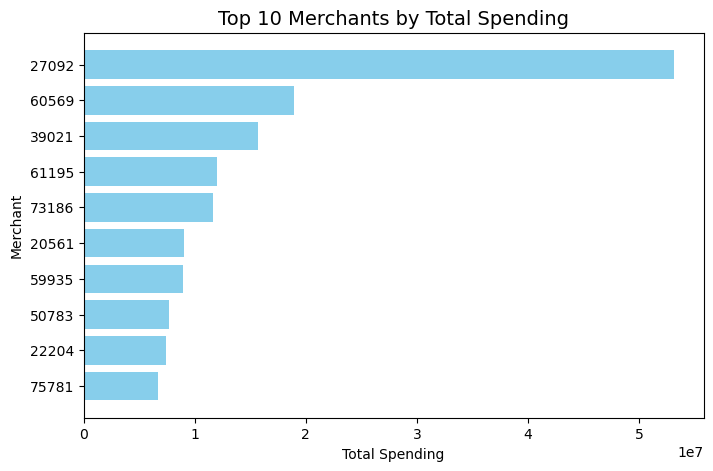

In [77]:
import matplotlib.pyplot as plt



# نحسب إجمالي الإنفاق لكل تاجر
merchant_spending = df.groupby('merchant_name')['amount'].sum().sort_values(ascending=False).head(10)

# نرسم Bar Chart
plt.figure(figsize=(8,5))
plt.barh(merchant_spending.index.astype(str), merchant_spending.values, color='skyblue')
plt.title("Top 10 Merchants by Total Spending", fontsize=14)
plt.xlabel("Total Spending")
plt.ylabel("Merchant")
plt.gca().invert_yaxis()  # نخلي أكبر واحد فوق
plt.show()


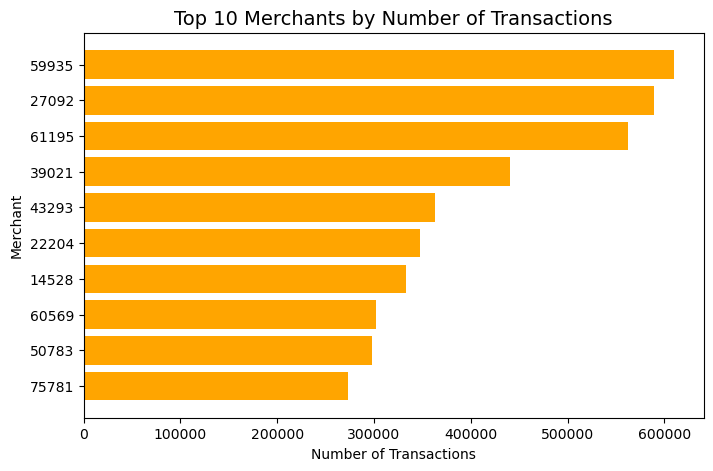

In [79]:
import matplotlib.pyplot as plt

# حساب عدد المعاملات لكل تاجر
merchant_transactions = df['merchant_name'].value_counts().head(10)

# رسم Bar Chart
plt.figure(figsize=(8,5))
plt.barh(merchant_transactions.index.astype(str), merchant_transactions.values, color='orange')
plt.title("Top 10 Merchants by Number of Transactions", fontsize=14)
plt.xlabel("Number of Transactions")
plt.ylabel("Merchant")
plt.gca().invert_yaxis()  # نخلي الأكبر فوق
plt.show()


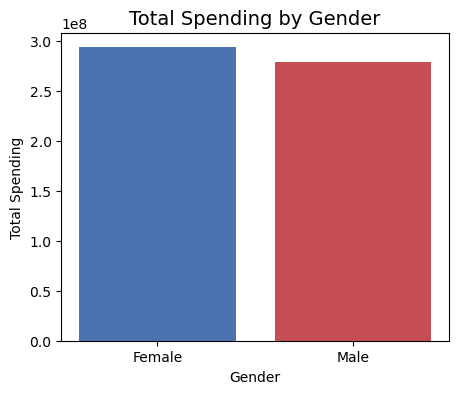

In [81]:
import matplotlib.pyplot as plt

# نتأكد إن amount رقمي
df['amount'] = df['amount'].replace('[\$,]', '', regex=True).astype(float)

# حساب إجمالي الإنفاق لكل gender
gender_spending = df.groupby('gender')['amount'].sum()

# رسم Bar Chart
plt.figure(figsize=(5,4))
plt.bar(gender_spending.index, gender_spending.values, color=['#4C72B0','#C44E52'])
plt.title("Total Spending by Gender", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Total Spending")
plt.show()


<Figure size 600x400 with 0 Axes>

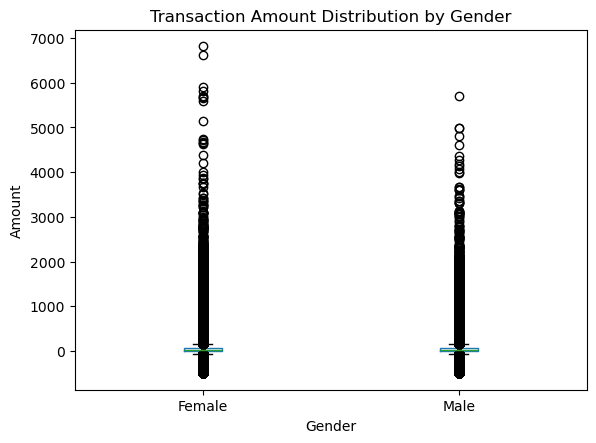

In [83]:
import matplotlib.pyplot as plt

#
# Box Plot للـ amount حسب gender
plt.figure(figsize=(6,4))
df.boxplot(column='amount', by='gender', grid=False)
plt.title("Transaction Amount Distribution by Gender")
plt.suptitle("")  # نشيل العنوان الإضافي اللي بيطلع أوتوماتيك
plt.xlabel("Gender")
plt.ylabel("Amount")
plt.show()


In [85]:
pd.crosstab(df['gender'], df['card_type'])


card_type,Credit,Debit,Debit (Prepaid)
gender,,,
Female,2106867,4239462,469587
Male,2002322,4041534,446143


In [87]:
pd.crosstab(df['card_brand'], df['use_chip'])


use_chip,Chip Transaction,Online Transaction,Swipe Transaction
card_brand,,,
Amex,304798,107354,442338
Discover,119455,36035,180973
Mastercard,2550957,848231,3758211
Visa,1805608,566292,2585663


In [89]:
pd.crosstab(df['transaction_year'], df['card_type'])


card_type,Credit,Debit,Debit (Prepaid)
transaction_year,,,
2010,393819,762251,84810
2011,410094,792386,88290
2012,413697,814807,93168
2013,419085,838247,95476
2014,421633,850963,92941
2015,424415,867975,95675
2016,421031,875178,95908
2017,427219,876642,95447
2018,424371,874646,95775


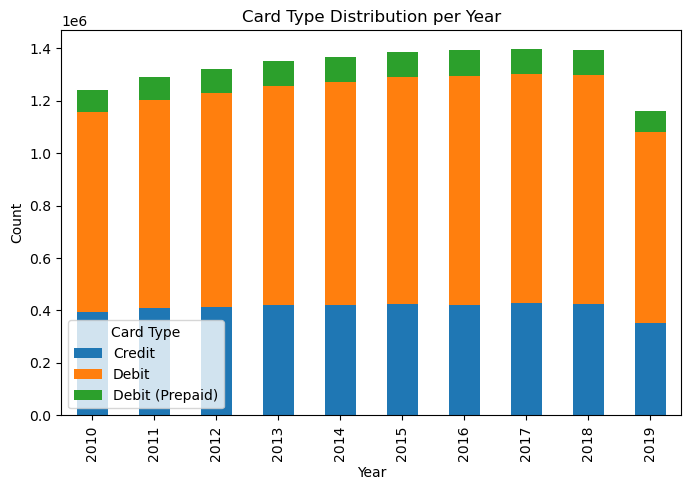

In [91]:
crosstab = pd.crosstab(df['transaction_year'], df['card_type'])

crosstab.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Card Type Distribution per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Card Type")
plt.show()


In [93]:
df.to_csv("transactions_clean.csv", index=False)
